# Downloading and processing LiDAR data and aerial photograph

This notebook gives a toturial which treats the subjects of getting LiDAR data, and give it a color using aerial photgraphs.

In [1]:
# Import packages
import logging
import json
import os
import urlparse

logging.root.setLevel(logging.DEBUG)

# computing
import numpy as np

#plotting
import matplotlib.pyplot as plt
%matplotlib inline

# for spatial types
import owslib.wfs
import owslib.wms
# for spatial operations
import shapely.geometry
from matplotlib import collections

# for pointclouds
import liblas
from liblas import file

# numpy compatible, uncompressed only for now
import laspy.file
# for downloading
import requests
# for xml parsing
import lxml.etree
import mako

# for aerial photo saturation
import skimage as ski
import gdal

# for timing of code
import timeit
import time as tm

os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib"

## LiDAR

The lidar data from the dutch ahn2 dataset is split up into tiles of 5 by 6.25 kilometers. To find out which tile we need to download in order to get the data we want, we can use the WFS. This is extensively discribed in the ahn2 notebook available in the github/notebooks repositry.

In [3]:
# Enter WFS properties
wfsurl = 'http://geodata.nationaalgeoregister.nl/ahn2/wfs'
wfs = owslib.wfs.WebFeatureService(wfsurl, version="2.0.0")
wfslayer = wfs.contents['ahn2:ahn2_bladindex']

# Get boxes from WFS
f = wfs.getfeature(typename=[wfslayer.id], outputFormat="json")
data = json.load(f)  # Coordinate system, 5 coordinates of polygon, bladnr

shapes = []
tiles = []

# create a list of tiles and shapes
for feature in data['features']:
    shapes.append(shapely.geometry.asShape(feature['geometry'])[0])
    tiles.append(shapes[-1].exterior.coords[:])

DEBUG:owslib:building WFS http://geodata.nationaalgeoregister.nl/ahn2/wfs
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/wfs?service=WFS&request=GetCapabilities&version=2.0.0 HTTP/1.1" 200 5817
DEBUG:owslib:building WFS http://geodata.nationaalgeoregister.nl/ahn2/wfs
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/wfs?service=WFS&request=GetCapabilities&version=2.0.0 HTTP/1.1" 200 5817
DEBUG:owslib:GetFeature WFS GET url http://geodata.nationaalgeoregister.nl/ahn2/wfs?typename=ahn2%3Aahn2_bladindex&outputFormat=json&version=2.0.0&request=GetFeature&service=WFS
INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/wfs?typename=ahn2%

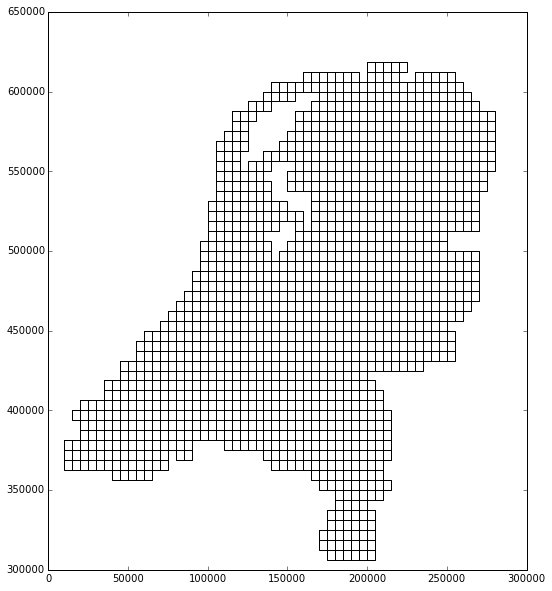

In [4]:
# Plot boxes using a collection
col = collections.LineCollection(tiles, colors='k')
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.add_collection(col, autolim=True)
ax.set_aspect('equal')
ax.autoscale_view()

The coordinates are in the Dutch RijksDriehoekstelsel.

In [5]:
# Referencing
import osgeo.osr
wgs84 = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
rd = osgeo.osr.SpatialReference()
rd.ImportFromEPSG(28992)
wgs842rd = osgeo.osr.CoordinateTransformation(wgs84, rd)

In [7]:
# Manual entry
lat, lon = 51.57, 3.57
x, y, _ = wgs842rd.TransformPoint(lon, lat)
p = shapely.geometry.Point(x, y)

# Check in which box the point lies
for i, shape in enumerate(shapes):
    if p.within(shape):
        bladnr = data['features'][i]['properties']['bladnr']
        logging.info('The point is in box %s.', bladnr)
        break

bladnr = coastal_tiles[2] # overwrite with coastal tile

INFO:root:The point is in box 65az2.


30fn1


Now we need to download the lidar tile. We can do this by parsing the feeds that contain the urls:
- http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_uitgefilterd.xml 
- http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_gefilterd.xml 

This allows us to search for our box. There are two links since there are two datasets. One, 'gefilterd', contains the point cloud with all the objects (houses, trees, etcetera) removed. The other 'uitgefilterd' contains these objects. We will need both of them. Let's download 37en1 for both. This might take a while because the total is almost 1GB.

When we have downloaded and unpacked the files, we get two laz files. 

In [8]:
urls = [
    'http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_uitgefilterd.xml',
    'http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_gefilterd.xml'
]
for url in urls:
    response = requests.get(url)
    tree = lxml.etree.parse(url)
    links = tree.findall('//{http://www.w3.org/2005/Atom}link')
    links = [link.attrib['href'] for link in links if bladnr in link.attrib['href']]
    link = links[0]
    filename = os.path.split(urlparse.urlsplit(link).path)[-1]
    newname = filename.replace('.zip', '')

    # skip if the extracted file is already there
    if not os.path.exists(newname):
        # continue downloading
        !wget -c $link
        !unzip -o $filename
    !lasinfo --no-check $newname

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/atom/ahn2_uitgefilterd.xml HTTP/1.1" 200 None


--2015-10-20 12:56:14--  http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_uitgefilterd/u30fn1.laz.zip
Resolving geodata.nationaalgeoregister.nl (geodata.nationaalgeoregister.nl)... 145.77.103.123
Connecting to geodata.nationaalgeoregister.nl (geodata.nationaalgeoregister.nl)|145.77.103.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip]
Saving to: ‘u30fn1.laz.zip’

    [       <=>                             ] 397,320,918 13.8MB/s   in 28s    

2015-10-20 12:56:41 (13.8 MB/s) - ‘u30fn1.laz.zip’ saved [397320918]

Archive:  u30fn1.laz.zip
 extracting: u30fn1.laz              
---------------------------------------------------------
  Header Summary
---------------------------------------------------------

  Version:                     1.2
  Source ID:                   0
  Reserved:                    0
  Project ID/GUID:             '00000000-0000-0000-0000-000000000000'
  System ID:                   'LAStools (c) by 

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): geodata.nationaalgeoregister.nl
DEBUG:requests.packages.urllib3.connectionpool:"GET /ahn2/atom/ahn2_gefilterd.xml HTTP/1.1" 200 None


--2015-10-20 12:56:46--  http://geodata.nationaalgeoregister.nl/ahn2/extract/ahn2_gefilterd/g30fn1.laz.zip
Resolving geodata.nationaalgeoregister.nl (geodata.nationaalgeoregister.nl)... 145.77.103.123
Connecting to geodata.nationaalgeoregister.nl (geodata.nationaalgeoregister.nl)|145.77.103.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip]
Saving to: ‘g30fn1.laz.zip’

    [                 <=>                   ] 500,417,356 13.2MB/s   in 35s    

2015-10-20 12:57:21 (13.6 MB/s) - ‘g30fn1.laz.zip’ saved [500417356]

Archive:  g30fn1.laz.zip
 extracting: g30fn1.laz              
---------------------------------------------------------
  Header Summary
---------------------------------------------------------

  Version:                     1.2
  Source ID:                   0
  Reserved:                    0
  Project ID/GUID:             '00000000-0000-0000-0000-000000000000'
  System ID:                   'LAStools (c) by Mar

The laz files contain the x, y and z coordinates of the point cloud. Let's see what's inside the file

In [9]:
fileloc = '.'
files = ['g' + bladnr + '.laz', 'u' + bladnr +'.laz']

for f in files:
    new_f = f.replace('.laz', '.las')
    if not os.path.exists(new_f):
        !las2las --input $f --output $new_f

In [10]:
#remove temporary files
for f in files:
    print f, f + '.zip'
    if os.path.exists(f):
        os.remove(f)           # delete .laz files
    if os.path.exists(f + '.zip'):
        os.remove(f + '.zip')  # delete .zip file

g30fn1.laz g30fn1.laz.zip
u30fn1.laz u30fn1.laz.zip


That are over 600 million points! Since this number is to high for the visualization we aim te make, we will reduce our area to an area of 500 x 500 m in the center of Delft. This will give us 5 million points which should be processable.

The problem with getting our five million points is that we cannot know the location of the point on beforehand. Also the points have to be extracted one by one, so building in an if-statement to check the location will greatly increase the computation time. Extracting all point will probably take more than an hour and some memory problems so we wont do that.

We do however know that the point are somewhat grouped in subtiles within the las files (Trust me on that one). So if we take a sample of 10000 points, and check if they are in our range plus some buffer, we roughly know which part of the las file is in our range. This way our computation time will be under 10 minutes, and we will cover most points. Let's select the bounds and extract a sample. This will probably take about two minutes.

In [11]:
# Set variables for image and las2las
image = bladnr + '.tiff'
image_saturated = bladnr + '_saturated.tiff'
las_g = 'g' + bladnr + '.las'
las_u = 'u' + bladnr + '.las'
las_ug = bladnr + '_ug.las'
color_las_ug = bladnr + '_color_ug.las'  # merged lasfile
potree_color = bladnr + '_color'

# print header for bounding box
f = file.File(las_u, mode='r')
max = f.header.get_max()
min = f.header.get_min()
size = f.header.get_count()  # get no of points

x_max = max[0]
x_min = min[0]
y_max = max[1]
y_min = min[1]
z_max = max[2]
z_min = min[2]

# # #determine max z by getting percentile (takes too long!, so hardcode z_max)
# points = []
# for i in f:
#     points.append(i.z)
#     counter += 1
# plt.hist(points,normed=True,bins=50);
# upper = np.percentile(points, 99)
# plt.axvline(upper, color='r');
# z_max = upper

print bladnr, x_min, x_max, y_min, y_max

f.close()

#hardcode z_max, highest point in NL is approx 280 m
z_max = 280

30fn1 90000.0 95000.0 468750.0 475000.0


## Aerial photo 

get aerial photofrom nationaalgeoregister using xml
1. create template xml with variables for x_min,x_max,y_min,y_max,x_size,y_size
2. overwrite variables with values
3. use gdal to download photo using xml

In [13]:
%%file wms.xml
<GDAL_WMS>
  <Service name="WMS">
    <Version>1.0.0</Version>
    <wmtver>1.0.0</wmtver>
    <ServerUrl>http://geodata1.nationaalgeoregister.nl/luchtfoto/wms?wmtver=1.0</ServerUrl>
    <Layers>luchtfoto</Layers>
    <SRS>EPSG:28992</SRS>
  </Service>
  <DataWindow>
    <UpperLeftX>${x_min}</UpperLeftX>
    <UpperLeftY>${y_max}</UpperLeftY>
    <LowerRightX>${x_max}</LowerRightX>
    <LowerRightY>${y_min}</LowerRightY>
    <SizeX>${x_size}</SizeX>
    <SizeY>${y_size}</SizeY>
  </DataWindow>
  <Projection>EPSG:28992</Projection>
  <BlockSizeX>256</BlockSizeX>
  <BlockSizeY>256</BlockSizeY>
</GDAL_WMS>

Overwriting wms.xml


In [15]:
from mako.template import Template

wms_template = Template(filename='wms.xml')  # load xml template9
x_size = '8000'
y_size = '8000'
a = wms_template.render(x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, x_size=x_size, y_size=y_size)  # overwrite variabels

f = open('wms.xml', 'w')
f.write(a)  # write correct xml to file
f.close()

In [17]:
%%bash -s "$image"
gdal_translate wms.xml $1

Input file size is 8000, 8000
0...10...20...30...40...50...60...70...80...90...100 - done.


The received picture has a lot of pixels and is therefore approx. 400 MB. To increase saturation, the rgb values will be converted to hsv so that the s column (saturation) will can be increased. After that the hsv values will be converted back to rgb. The large amount of data gives RAM issues. Therefore the picture is split into N parts to convert and the RAM memory is cleaned after every step

30fn1.tiff


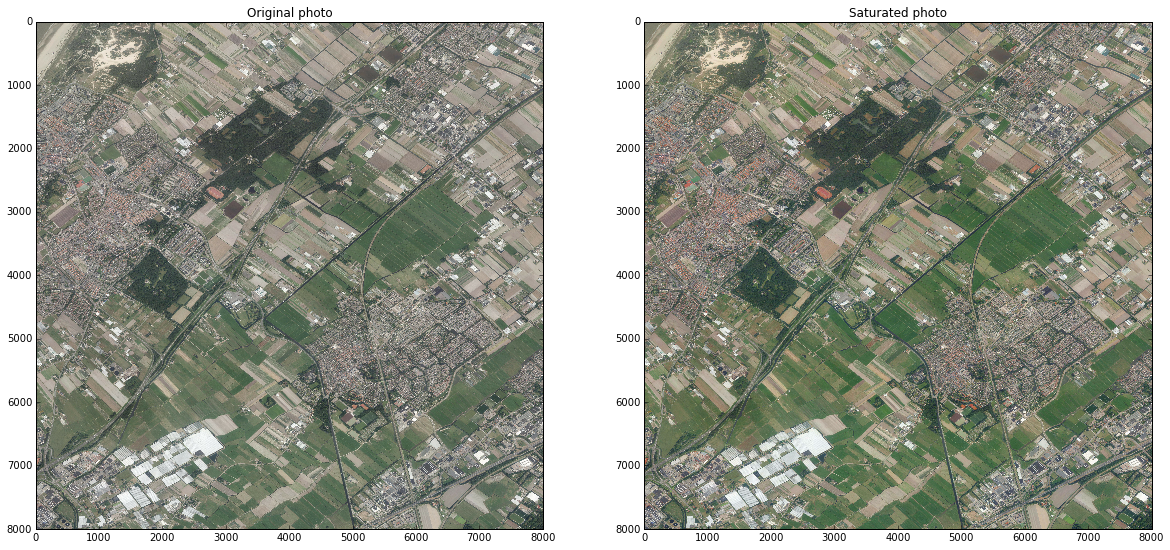

In [19]:
from skimage import color
import matplotlib as matplotlib
img = (plt.imread(image)).astype(np.uint8)

#split image in N steps for processing (otherwise to much for virtual memory)
img_new = None  # to clear RAM
img_new = np.zeros_like(img).astype(np.float)  # new empty array to fill with saturated rgb

pic_size = float(len(img))           # no. of pixels in 1 direction
N = 4                                # no. of processing steps
steps = pic_size / N                 # pixels per processing step
  
for i in range(N):
    lower = i * int(steps)
    upper = (i + 1) * int(steps)
    
    img_process = img[lower:upper, :, :]
    hsv = ski.color.rgb2hsv(img_process)
    hsv[:, :, 1] *= 1.5
    img_new[lower:upper, :, :] = ski.color.hsv2rgb(hsv)
    
    #clear memory for next step
    img_process = None
    hsv = None

fig = plt.figure()
fig.set_size_inches(20, 10)

#original photo
plt.subplot(1, 2, 1)
plt.title('Original photo')
plt.imshow(img);

#saturated photo
plt.subplot(1, 2, 2)
plt.title('Saturated photo')
plt.imshow(img_new);

plt.imsave(bladnr + '_saturated.tiff', arr=img_new, format='tiff')  # save picture as tiff (spatial information lost)
plt.imsave(bladnr + '_saturated.jpg', arr=img_new, format='jpg')  # save picture as jpg

img_new = None
img = None

The saturated tiff file has lost it's georeference information. Therefore, the geo information will be used from the original (downloaded) geotiff and merged

In [20]:
#spatial information is lost in saturated tiff. Copy spatial info from original tiff
print 'image with geoinfo ' + image
print 'image without geoinfo ' + image_saturated

#get geo information from tiff file with spatial information
ds_input = gdal.Open(image)
projection = ds_input.GetProjection()
geotransform = ds_input.GetGeoTransform()
gcp_count = ds_input.GetGCPs()

ds_output =gdal.Open(bladnr + '_saturated.tiff', gdal.GA_Update)  # saturated tiff file without spatial information

ds_output.SetProjection(projection)  # copy spatial info
ds_output.SetGeoTransform(geotransform)
ds_output.SetGCPs(gcp_count, ds_input.GetGCPProjection())

#close dataset
ds_input = None
ds_output = None

os.remove(image)  # remove nonstaturated geotiff

image with geoinfo 30fn1.tiff
image without geoinfo 30fn1_saturated.tiff


Now we have 2 las files and a saturated picture. First, use lasmerge to merge both unfiltered and gefiltered files. Note that lasmerge only works with the uncompressed las files. Therefore the las files from the previous cells needs to be used.

In [22]:
%%bash -s "$image_saturated" "$las_g" "$las_u" "$las_ug"
lasmerge -i $2 -i $3 -o $4

In [23]:
#remove files
os.remove(las_g)
os.remove(las_u)

Next, use las2las to merge the saturated geotiff and the merged las files. The output can now be compressed laz as las2las can handle both formats and can perform the compression. To filter the point noise in the z-direction, a lasbox will be defined that contains the bounding box for the pointcloud.

In [24]:
#to filter z direction noise create bounding box --extent function in las2las
las_box = '"' + str(int(x_min)) + ' ' + str(int(y_min)) + ' ' + str(int(z_min)) + ' ' + str(int(x_max)) + ' ' + str(int(y_max)) + ' ' + str(int(z_max)) + '"'

In [25]:
%%bash -s "$image_saturated" "$las_g" "$las_u" "$las_ug" "$color_las_ug" "$las_box" 
las2las --color-source $1 \
        --point-format 3 \
        --color-source-bands 1 2 3 \
        --color-source-scale 256 \
        --extent '"'$6','$7','$8','$9','${10}','${11}'"' \
        -i $4 -o $5

In [26]:
#remove files
os.remove(las_ug)

# PotreeConverter
Use PotreeConverter to convert .laz to potree octree + generate webpage (takes long)
To automatically generate a correct webpage viewer, make sure resources/page_template is in working dir

In [27]:
potree_output = 'potree_converted_7'  # folder for potree output
print color_las_ug  # PotreeConverter werkt alleen met .las file, .laz geeft error

30fn1_color_ug.las


In [29]:
%%bash -s "$color_las_ug" "$potree_output"
PotreeConverter $1 -l 9 --generate-page -o $2

== params ==
source[0]:         	30fn1_color_ug.las
outdir:            	potree_converted_7
spacing:           	0
diagonal-fraction: 	250
levels:            	9
format:            	
scale:             	0
output-format:     	BINARY

spacing calculated from diagonal: 32.0163
Last level will have spacing:     0.125064

AABB: 
min: [90,000, 468,750, -3]
max: [95,000, 475,000, 48.55]
size: [5,000, 6,250, 51.55]

cubic AABB: 
min: [90,000, 468,750, -3]
max: [96,250, 475,000, 6,247]
size: [6,250, 6,250, 6,250]

reading 30fn1_color_ug.las
INDEXING: 5,000,000 points processed; 4,999,982 points written; 33.435 seconds passed
INDEXING: 10,000,000 points processed; 9,997,427 points written; 69 seconds passed
INDEXING: 15,000,000 points processed; 14,986,649 points written; 108.321 seconds passed
INDEXING: 20,000,000 points processed; 19,984,739 points written; 142.448 seconds passed
INDEXING: 25,000,000 points processed; 24,984,150 points written; 178.537 seconds passed
INDEXING: 30,000,000 points p